# Milestone 2: baseline models
___

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from import_preprocess import ImportPreprocess
from evaluate import Evaluation
from simple_baseline import MajorityClassClassifier

In [2]:
import_preprocess = ImportPreprocess()
import_preprocess.import_train_dev_test()

X_train, y_train = import_preprocess.X_train, import_preprocess.y_train
X_dev, y_dev = import_preprocess.X_dev, import_preprocess.y_dev
X_test, y_test = import_preprocess.X_test, import_preprocess.y_test

print("Number of training samples:", len(X_train)) 
print("Number of validation samples:", len(X_dev)) 
print("Number of test samples:", len(X_test)) 

Number of training samples: 1294
Number of validation samples: 2000
Number of test samples: 4000


In [3]:
import_preprocess.convert_class_labels()
y_train, y_dev, y_test = import_preprocess.y_train, import_preprocess.y_dev, import_preprocess.y_test

In [4]:
X_train_dev, y_train_dev = import_preprocess.concatenate_train_dev()
len(X_train_dev)

3294

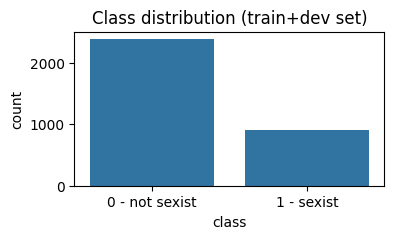

In [5]:
plt.figure(figsize=(4, 2))
sns.countplot(x=y_train_dev)
plt.xticks(ticks=[0, 1], labels=['0 - not sexist', '1 - sexist'])
plt.title('Class distribution (train+dev set)')
plt.xlabel('class')
plt.ylabel('count')

plt.show()

#### a) Traditional (non-DL) baseline models

1. majority class classifier

In [6]:
majority_class_classifier = MajorityClassClassifier()
majority_class_classifier.fit(X_train_dev, y_train_dev)
print("Majority class:", majority_class_classifier.majority_class)

Majority class: 0


Metrics for TRAIN+DEV set
accuracy: 0.7234
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000
########################################

Metrics for TEST set
accuracy: 0.7575
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000
[[2383    0]
 [ 911    0]]


d:\Natural Language Processing\Project new\NLP_24W_VSHJ\my_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Natural Language Processing\Project new\NLP_24W_VSHJ\my_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


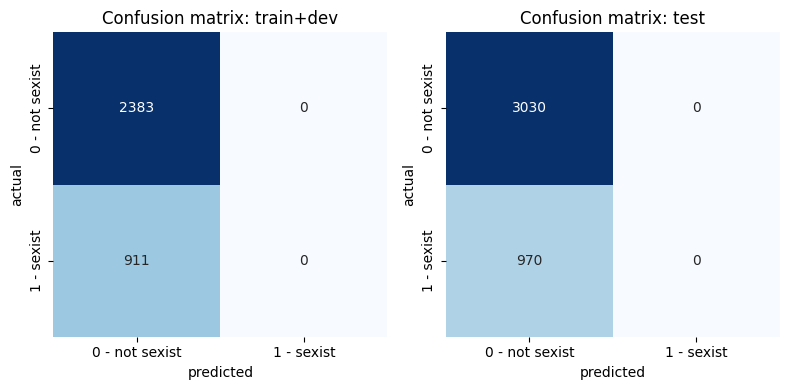

In [7]:
eval_baseline = Evaluation(model=majority_class_classifier)
eval_baseline.evaluate(X_train_dev, y_train_dev, X_test, y_test, plot_confusion=True)

2. regex classifier

3. Naive Bayes (NB)

#### b) DL baseline models

1. RNN

...